## FALCON

In this example, firstly, the reinforcement learning domain is defined.
The domain environment is defined as a graph where each node is a state and the links represent possible transitions between states. Here, 8 states (state 0 to state 7) are defined connected with bi-directional links as shown below.

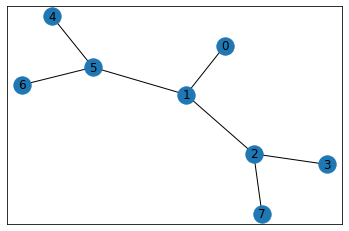

(0, 1)
(1, 5)
(5, 6)
(5, 4)
(1, 2)
(2, 3)
(2, 7)


matrix([[ -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,   0.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,   0.,  -1.,  -1.,  -1., 100.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,  -1.,   0.,  -1.,   0.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1., 100.]])

In [1]:
import numpy as np
import pylab as plt

import pandas as pd

# the environment is defined as a graph with edges connecting states in points_list
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]

goal = 7 #node 7 is the goal state 
terminal = 7 #node 7 is also the terminal state

import networkx as nx

G=nx.Graph()                    #the graph is defined
G.add_edges_from(points_list)   #list of edges makes the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()                      #show the graph

MATRIX_SIZE = 8                 #the size of adjacency matrix of the graph

# create matrix x*y
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE))) #setup the adjacency matrix
R *= -1  #initiate the reward function with negative values for every transition 

# assign zeros to paths and 100 to goal-reaching point (-1 if no path available between states)
for point in points_list:
    print(point)
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal,goal]= 100

R


According to the graph above, the state space is now becomes {0,1,2,3,4,5,6,7}. Similarly, the action space is also defined as {0,1,2,3,4,5,6,7} indicating the next state to visit. For every state, 'available_actions' function will return possible actions that can be taken by the agent from that state. For example, at state 1, 'available_actions' will return a list containing 2,5, and 0 as possible options that the agent can choose at state 1. The execution of the selected action will change the current state of the agent according to the chosen action.

In [2]:
initial_state = 0  #the initial state of the agent
maxsteps = 20      #the maximum number of steps the agent can take without arriving at the goal/terminal state before it terminates

def available_actions(state): #returning possible options given the current state
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

def sample_next_action(available_actions_range): #select an action/option randomly from possible actions
    next_action = int(np.random.choice(available_actions_range,1))
    return next_action

def reward_function(state,action): #return the action reward value when the agent take the action from a state
    return R[state,action]

def hot_vector(idxstate): #converting a state number (int) into a one hot encoding vector wherein the state number corresponds to the index of the element with value 1 
    vstate = [0.0] * MATRIX_SIZE
    vstate[idxstate] = 1.0
    return vstate

#def isActVectRandom(vect):
#    return [1.0] * MATRIX_SIZE == vect

def inv_hot_vector(vstate): #the inverse conversion of one hot encoding vector into the state number
    return vstate.index(1.0)

After the domain definition is complete, FALCON object can then be defined. FALCON needs fusion ART to be defined. In the example below, the fusion ART network is defined using schema description. The schema specify three input channels, namely: 'state', 'action', and 'reward'. The 'state' and 'reward' are complement coded, but not for the 'action' field. The reason is that the 'action' is not used in resonance search as input in action selection and Q estimation. It is only involved to match with the code during learning to store the action.

The FALCON model in this example is also configured to be hybrid with ART2 model (particularly ART2A-C) for the reward channel besides the default FuzzyART channel for the original settings.

The example below shows the configuration of FALCON and some functions to support the experiment process.

In [3]:
from Falcon import *
from ARTxtralib import *

import random

#the schema configuration is used to specify the channels of FALCON in the fusion ART network
domain_schema = [{'name':'state','compl':True,'attrib':['s1','s2','s3','s4','s5','s6','s7','s8']},
                 {'name':'action','attrib':['a1','a2','a3','a4','a5','a6','a7','a8']},
                 {'name':'reward','compl':True,'attrib':['r']}]

#the FALCON object is then constructed with the schema as the argument to specify the fusion ART network
dafalcon = Falcon(fSchema=domain_schema) 

#The RL exploration strategy is then specified for FALCON, particularly it's based on decaying epsilon greedy strategy
dafalcon.exploreStrategy = EpsilonGreedy(depsilon=0.01) #depsilon is specified as the rate of the epsilon decay 

#The last channel (indexed number 2) of fusion ART is override with ART2 operations for the resonance search
ART2ACModelOverride(dafalcon.fusionart, k=2)

#setting the vigilance parameters for different stages in FALCON learning
dafalcon.set_select_gammarho_param(rho=[0.8,0.0,0.5]) #set rho (vigilance) configuration for action selection stage
dafalcon.set_estimate_gammarho_param(rho=[0.8,0.0,0.0]) #set rho (vigilance) configuration for future max Q estimation stage
dafalcon.set_learn_gammarho_param(rho=[0.8,1.0,0.75]) #set rho (vigilance) configuration for learning stage 

#note that the vigilance (rho) for the state is set to be relatively higher (0.8) than usual vigilance setting for other domains.
#In this domain, the state is represented as one-hot encoding vector, so that it's sensitive to small change in the value
#0.8 is chosen to avoid overgeneralization in the state presentation and learning since the state is using one-hot encoding

#For other domains, lower vigilance may be more suitable especially when generalization is allowed
#-----------------------------------------------------------

#in this domain, gamma parameter for Q learning needs to be set a bit higher. However, that wouldn't be so for other domains
dafalcon.rlgamma = 0.3
dafalcon.rlalpha = 0.5

rewardHist = [] #buffer store the trace of the reward obtained or collected

no_of_run = 300 #number of runs or epochs in a single experiment

#Function to conduct a single experiment, returning the trajectory of the agent states, actions, etc.
def experimentRL(agent=dafalcon, initstate=initial_state, nrun=no_of_run):
    ltraject = []
        
    agent.exploreStrategy.resetEpsilon() #initialize the decay epsilon greedy exploration strategy
    sepoch = []
    for e in range(nrun):
        print('epsilon ', agent.exploreStrategy.epsilon, ' epoch:', sepoch)
        sepoch = domainCycle(agent=agent, initstate=initstate)
        ltraject.append(sepoch)
        agent.exploreStrategy.epsilonDecay()
    return ltraject

#Function to conduct a single run or epoch, from initial state to terminal state (or a termination condition)
def domainCycle(agent=dafalcon, initstate=initial_state):
    # Initialization of a run or epoch
    cnt = 0
    rtraject = []
    pacts = [1.0] * MATRIX_SIZE
    acts = [1.0] * MATRIX_SIZE
    pstate = initstate
    cstate = initstate
    pQ = NEUTRALQ
    r = 0
    terminate = False
    trajectory = [cstate]
    uncommit = True
    nodeidx = 0
    
    #the action selection and learning cycle or loop
    while cnt < maxsteps and not terminate:      
        if cstate == terminal: #when the current state is a terminal state, then terminate
            terminate = True
        if r < 0:              #when the reward is negative or the action is not allowed, then terminate
            r = 0
            terminate = True

        #sample random action from current state (always generated either exploration or exploitation)
        #Depending on the domain problem, this allows random selection to be bounded with constraints from the domain
        xacts = hot_vector(sample_next_action(available_actions(cstate))) 
        
        if cnt > 0: #if the loop is the second round or more, then provide the previous state, action, Q, terminal state etc. to learn
            acts, Qval, eQ = agent.RLCycle(prevState=hot_vector(pstate), prevActions=pacts, currentState=hot_vector(cstate), explorActs=xacts, prevQ=pQ, reward=r, terminalstate=terminate)
        else:       #if the loop is still in the first round, then provide only the state (and explored actions) since learning will still be skipped  in this round
            acts, Qval, eQ = agent.RLCycle(currentState=hot_vector(cstate), explorActs=xacts)
        
        #In the above example of RLCycle for this domain, explorActs is specified as the source of random action selection is from the domain itself.
        #For other domains, explorActs may be skipped or left unspecified, if the random action selection can be simply conducted internally by FALCON itself without any constraints from the domain
        
        
        if terminate:
            break
        #execute the action
        #if isActVectRandom(acts):
        #    acts = hot_vector(sample_next_action(available_actions(cstate)))
        r = reward_function(cstate, inv_hot_vector(acts))/100 #calculate the reward based on the current state and selected action (normalized between 0 and 1)
        pstate = cstate #set the previous state to be the current state
        cstate = inv_hot_vector(acts) #set the current state with the result of the action 
        pacts = acts #put the selected action into the previous selected action before moving on the next round
                
        #trajectory.append((r, Qval, eQ, pstate, cstate, inv_hot_vector(acts), acts))
        
        #record the previous state, current state, selected actions, reward, retrieved Q value, and the estimated Q
        trajectory.append((pstate, cstate, inv_hot_vector(acts), r, Qval, eQ))
        #rewardHist.append(r)
        #list the reward received
        rtraject.append(r)
        
        cnt+=1
    rewardHist.append(rtraject) #record the sequence of rewards received for every step
    return trajectory

#calculate the overall performance
def performanceCalc(rtrac = None, factor=3):
    pcalc = []
    s = 0
    for i in range(len(rtrac)):
        perf = sum(rtrac[i])/len(rtrac[i])
        pcalc.append(perf*3)
    return pcalc
    
#averaging the performance to be displayed in a graph    
def smoothPerformance(perform=None, win=3):
    perform_series = pd.Series(perform)
    perf_win = perform_series.rolling(win)
    perf_averages = perf_win.mean()
    
    perf_average_list = perf_averages.tolist()
    return perf_average_list[win - 1:]
    

In [4]:
trj = experimentRL()
trj

epsilon  1.0  epoch: []
epsilon  0.99  epoch: [0, (0, 1, 1, 0.0, 0.5, 0.5), (1, 2, 2, 0.0, 0.5, 0.325), (2, 7, 7, 1.0, 0.5, 0.325)]
epsilon  0.98  epoch: [0, (0, 1, 1, 0.0, 0.5, 0.5), (1, 2, 2, 0.0, 0.5, 0.325), (2, 1, 1, 0.0, 0.5, 0.325), (1, 2, 2, 0.0, 0.5, 0.325), (2, 1, 1, 0.0, 0.5, 0.325), (1, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.5, 0.325), (4, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.325, 0.29875), (4, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.5, 0.325), (4, 5, 5, 0.0, 0.5, 0.325)]
epsilon  0.97  epoch: [0, (0, 1, 1, 0.0, 0.5, 0.5), (1, 2, 2, 0.0, 0.5, 0.325), (2, 3, 3, 0.0, 0.5, 0.325), (3, 2, 2, 0.0, 0.5, 0.325), (2, 7, 7, 1.0, 0.5, 0.325)]
epsilon  0.96  epoch: [0, (0, 1, 1, 0.0, 0.5, 0.5), (1, 0, 0, 0.0, 0.5, 0.325), (0, 1, 1, 0.0, 0.5, 0.325), (1, 5, 5

epsilon  0.7499999999999998  epoch: [0, (0, 1, 1, 0.0, 0.5, 0.5), (1, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.325, 0.29875), (6, 5, 5, 0.0, 0.325, 0.29875), (5, 4, 4, 0.0, 0.5, 0.325), (4, 5, 5, 0.0, 0.5, 0.325), (5, 1, 1, 0.0, 0.5, 0.325), (1, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.5, 0.325), (4, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 1, 1, 0.0, 0.5, 0.325), (1, 2, 2, 0.0, 0.5, 0.325), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.7399999999999998  epoch: [0, (0, 1, 1, 0.0, 0.325, 0.5), (1, 0, 0, 0.0, 0.5, 0.325), (0, 1, 1, 0.0, 0.5, 0.325), (1, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.5, 0.325), (4, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.5, 0.325), (4, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 1, 1, 0.0, 0.5, 0.325), (1, 0, 0, 0.0, 0.5, 0.325), (0, 1, 1, 0.0, 0.5, 0.325), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.7299999999999998  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.

epsilon  0.4399999999999995  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 0, 0, 0.0, 0.325, 0.29875), (0, 1, 1, 0.0, 0.5, 0.325), (1, 5, 5, 0.0, 0.325, 0.29875), (5, 6, 6, 0.0, 0.325, 0.29875), (6, 5, 5, 0.0, 0.325, 0.29875), (5, 6, 6, 0.0, 0.5, 0.325), (6, 5, 5, 0.0, 0.5, 0.325), (5, 6, 6, 0.0, 0.325, 0.29875), (6, 5, 5, 0.0, 0.5, 0.325), (5, 4, 4, 0.0, 0.325, 0.29875), (4, 5, 5, 0.0, 0.325, 0.29875), (5, 1, 1, 0.0, 0.5, 0.325), (1, 2, 2, 0.0, 0.5, 0.325), (2, 1, 1, 0.0, 0.5, 0.325), (1, 0, 0, 0.0, 0.325, 0.29875), (0, 1, 1, 0.0, 0.29875, 0.29481250000000003), (1, 2, 2, 0.0, 0.325, 0.29875), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.4299999999999995  epoch: [0, (0, 1, 1, 0.0, 0.29875, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.4199999999999995  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 1, 1, 0.0, 0.5, 0.325), (1, 2, 2, 0.0, 0.5, 0.325), (2, 1, 1, 0.0, 0.5, 0.325), (1, 2, 2, 0.0, 0.325, 0.29875), (2, 3, 3, 0.0, 0.5, 0.325), (3, 2, 2, 0.0, 0

epsilon  0.04999999999999925  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.03999999999999925  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.02999999999999925  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.019999999999999248  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.009999999999999247  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31),

epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1,

epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1, 2, 2, 0.0, 0.4, 0.31), (2, 7, 7, 1.0, 1.0, 0.4)]
epsilon  0.0  epoch: [0, (0, 1, 1, 0.0, 0.31, 0.5), (1,

[[0,
  (0, 1, 1, 0.0, 0.5, 0.5),
  (1, 2, 2, 0.0, 0.5, 0.325),
  (2, 7, 7, 1.0, 0.5, 0.325)],
 [0,
  (0, 1, 1, 0.0, 0.5, 0.5),
  (1, 2, 2, 0.0, 0.5, 0.325),
  (2, 1, 1, 0.0, 0.5, 0.325),
  (1, 2, 2, 0.0, 0.5, 0.325),
  (2, 1, 1, 0.0, 0.5, 0.325),
  (1, 5, 5, 0.0, 0.5, 0.325),
  (5, 4, 4, 0.0, 0.5, 0.325),
  (4, 5, 5, 0.0, 0.5, 0.325),
  (5, 4, 4, 0.0, 0.325, 0.29875),
  (4, 5, 5, 0.0, 0.5, 0.325),
  (5, 6, 6, 0.0, 0.5, 0.325),
  (6, 5, 5, 0.0, 0.5, 0.325),
  (5, 6, 6, 0.0, 0.5, 0.325),
  (6, 5, 5, 0.0, 0.5, 0.325),
  (5, 6, 6, 0.0, 0.5, 0.325),
  (6, 5, 5, 0.0, 0.5, 0.325),
  (5, 6, 6, 0.0, 0.5, 0.325),
  (6, 5, 5, 0.0, 0.5, 0.325),
  (5, 4, 4, 0.0, 0.5, 0.325),
  (4, 5, 5, 0.0, 0.5, 0.325)],
 [0,
  (0, 1, 1, 0.0, 0.5, 0.5),
  (1, 2, 2, 0.0, 0.5, 0.325),
  (2, 3, 3, 0.0, 0.5, 0.325),
  (3, 2, 2, 0.0, 0.5, 0.325),
  (2, 7, 7, 1.0, 0.5, 0.325)],
 [0,
  (0, 1, 1, 0.0, 0.5, 0.5),
  (1, 0, 0, 0.0, 0.5, 0.325),
  (0, 1, 1, 0.0, 0.5, 0.325),
  (1, 5, 5, 0.0, 0.5, 0.325),
  (5, 6, 6, 0.0, 0.5,

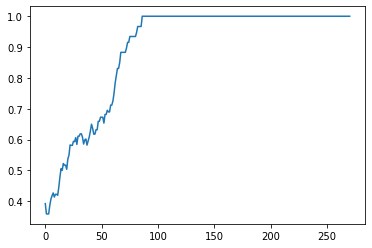

In [5]:
plt.plot(smoothPerformance(perform = performanceCalc(rtrac = rewardHist), win=30))
plt.show()